In [1]:
from data.aware import AwareDataset, AwareSplitter
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import sklearn.metrics as M

dataset = AwareDataset(csv_data = 'data/exhale_data_v8_ave.csv',
                       csv_outcome = 'data/exhale_outcome_v8_ave.csv',
                       csv_info = 'data/exhale_verbose_v8_ave.csv',
                       root_dir = 'data/',
                       target_classes = [0,1])

X = np.zeros(shape=(len(dataset), 84))
y = np.zeros(shape=(len(dataset)))
for i in range(len(dataset)):
    inputs, masks, labels, info = dataset[i]
    X[i,:] = inputs
    y[i] = labels[0]

Outcome Columns: Index(['Diagnosis', 'FEV1', 'FEV1/FVC', 'FEF2575', 'FEV1_pred',
       'FEV1/FVC_pred', 'FEF2575_pred', 'R5', 'R5_20', 'R20', 'X5', 'AX', 'TV',
       'R5_z_score', 'R5_20_z_score', 'R20_z_score', 'X5_z_score',
       'AX_z_score'],
      dtype='object')
Info Columns: Index(['ID', 'Trial', 'Age', 'Sex', 'Height', 'Weight', 'OralCavity', 'OPJ',
       'Glottis', 'Carina'],
      dtype='object')
# of total CSA samples: 1058
# of total subjects: 340
# of valid CSA samples w/o NaN: 837
# of subjects w/ valid CSA samples: 267
# of healthy samples: 295
# of asthma sampels: 542


(837, 84)


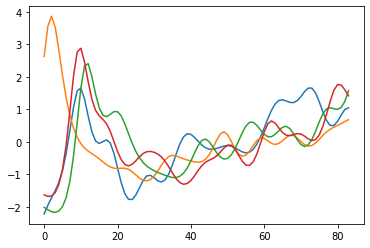

In [2]:
print(X.shape)
plt.figure()
plt.plot(X[1:5,:].T)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=50, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(X)

results = {'tsne-2d-one': tsne_results[:,0],
           'tsne-2d-two': tsne_results[:,1],
           'y': y}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=results,
    palette=sns.color_palette("Set2"),
    legend="full",
)
plt.legend(["Healthy","Asthma"])
plt.title("Labels")

NameError: name 'X' is not defined

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 837 samples in 0.000s...
[t-SNE] Computed neighbors for 837 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 837 / 837
[t-SNE] Mean sigma: 1.924096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.877106
[t-SNE] KL divergence after 300 iterations: 1.503124


/tmp/ipykernel_3973/105755902.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(


Text(0.5, 1.0, 'Subset')

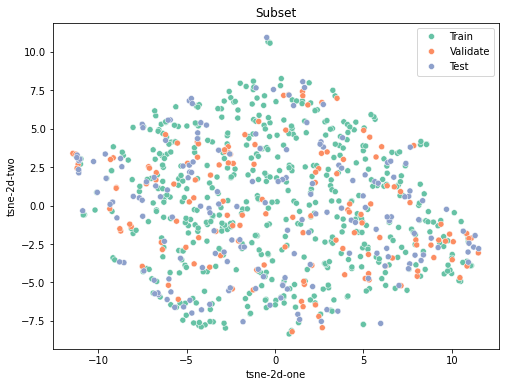

In [4]:
RANDOM_SEED = 5
BATCH_SIZE = 1000
N_clusters = 8

splitter = AwareSplitter(dataset, BATCH_SIZE, random_seed=RANDOM_SEED)
for split_idx, (train_loader, val_loader, test_loader) in enumerate(splitter):
    for batch_idx, (inputs, masks, labels, info) in enumerate(train_loader):
        X_train = inputs
        y_train = np.full_like(labels[:,0], 0)
    for batch_idx, (inputs, masks, labels, info) in enumerate(val_loader):
        X_val = inputs
        y_val = np.full_like(labels[:,0], 1)
    for batch_idx, (inputs, masks, labels, info) in enumerate(test_loader):
        X_test = inputs
        y_test = np.full_like(labels[:,0], 2)
    break

X = np.concatenate((X_train, X_val, X_test),axis=0)
y = np.concatenate((y_train, y_val, y_test),axis=0)

tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(X)

results['tsne-2d-one'] = tsne_results[:,0]
results['tsne-2d-two'] = tsne_results[:,1]
results['y'] = pd.Categorical(y)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=results,
    palette=sns.color_palette("Set2"),
    legend="full",
)
plt.legend(["Train","Validate","Test"])
plt.title("Subset")

/home/ericyxy/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.116248384


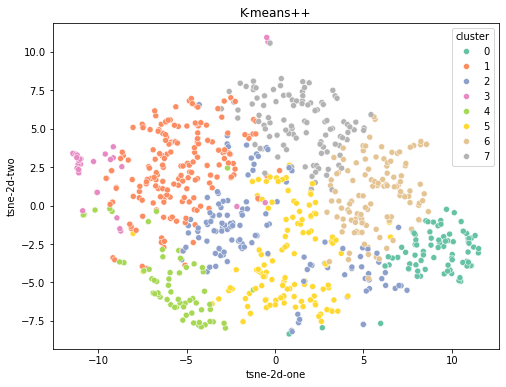

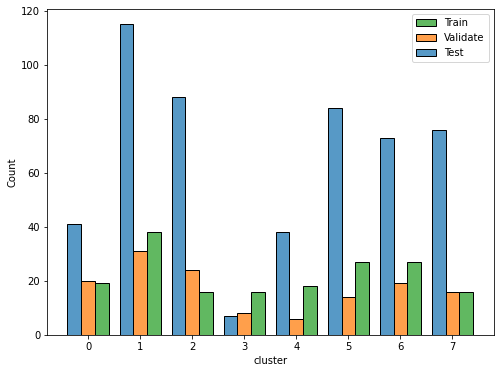

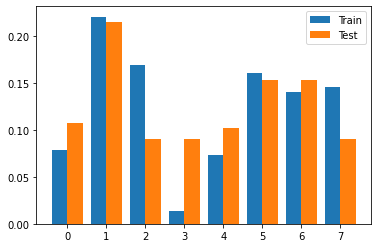

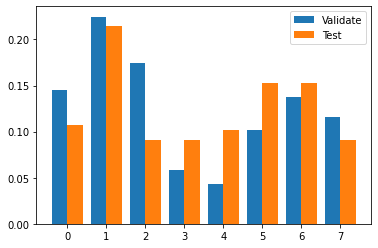

Train vs. test
Power_divergenceResult(statistic=92.5570513586576, pvalue=3.6892828593460657e-17)
Val vs. test
Power_divergenceResult(statistic=31.74422757275913, pvalue=4.5298274555803926e-05)


In [5]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=N_clusters).fit(X)
results['cluster'] = pd.Categorical(clustering.labels_)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    data=results,
    palette=sns.color_palette("Set2"),
    legend="full",
)
plt.title("K-means++")

print(M.silhouette_score(X,results['cluster']))

plt.figure(figsize=(8,6))
sns.histplot(
    data=results,
    x="cluster",
    hue="y",
    multiple="dodge",
    shrink=.8)
plt.legend(["Train","Validate","Test"])
plt.show()

results_df = pd.DataFrame(results)
f_train = results_df['cluster'][results_df['y']==0].value_counts(sort=False)
f_val = results_df['cluster'][results_df['y']==1].value_counts(sort=False)
f_test = results_df['cluster'][results_df['y']==2].value_counts(sort=False)

plt.figure()
plt.bar(np.arange(8)-0.2, f_train/f_train.sum(), 0.4)
plt.bar(np.arange(8)+0.2, f_test/f_test.sum(), 0.4)
plt.legend(["Train","Test"])
plt.show()

plt.figure()
plt.bar(np.arange(8)-0.2, f_val/f_val.sum(), 0.4)
plt.bar(np.arange(8)+0.2, f_test/f_test.sum(), 0.4)
plt.legend(["Validate","Test"])
plt.show()

print("Train vs. test")
print(stats.chisquare(f_obs=f_test, f_exp=f_train/f_train.sum()*f_test.sum()))
print("Val vs. test")
print(stats.chisquare(f_obs=f_test, f_exp=f_val/f_val.sum()*f_test.sum()))

In [6]:
# from sklearn.cluster import DBSCAN, OPTICS
# clustering = DBSCAN(eps=3, min_samples=5).fit(X)
# results['cluster'] = pd.Categorical(clustering.labels_)

# plt.figure(figsize=(8,6))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="cluster",
#     data=results,
#     palette=sns.color_palette("Set2"),
#     legend="full",
# )
# plt.title("Density-based (DBSCAN)")

# plt.figure(figsize=(8,6))
# sns.histplot(
#     data=results,
#     x="cluster",
#     hue="y",
#     multiple="dodge",
#     shrink=.8)
# plt.legend(["Train","Validate","Test"])
# plt.show()

# results_df = pd.DataFrame(results)
# f_train = results_df['cluster'][results_df['y']==0].value_counts(sort=False)
# f_train = f_train/f_train.sum()
# f_val = results_df['cluster'][results_df['y']==1].value_counts(sort=False)
# f_val = f_val/f_val.sum()
# f_test = results_df['cluster'][results_df['y']==2].value_counts(sort=False)
# f_test = f_test/f_test.sum()

# print("Train vs. test")
# print(stats.chisquare(f_obs=f_test, f_exp=f_train))
# print("Val vs. test")
# print(stats.chisquare(f_obs=f_test, f_exp=f_val))

0.07417135


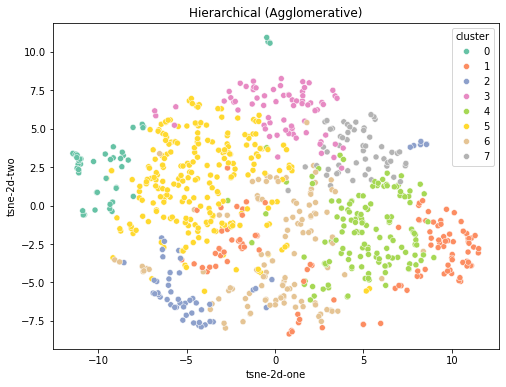

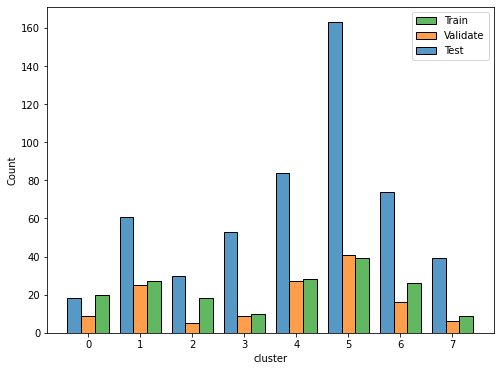

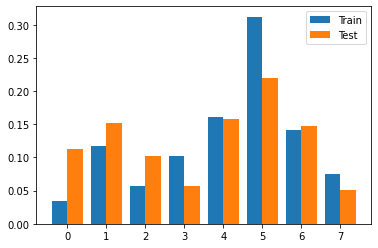

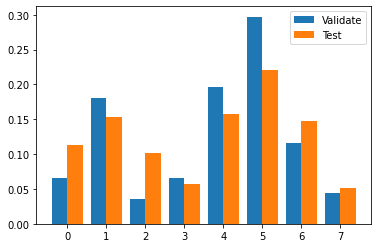

Train vs. test
Power_divergenceResult(statistic=49.30768605232559, pvalue=1.9748228565674346e-08)
Val vs. test
Power_divergenceResult(statistic=34.60011973114081, pvalue=1.329542023066684e-05)


In [7]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=N_clusters, distance_threshold=None).fit(X)
results['cluster'] = pd.Categorical(clustering.labels_)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    data=results,
    palette=sns.color_palette("Set2"),
    legend="full",
)
plt.title("Hierarchical (Agglomerative)")

print(M.silhouette_score(X,results['cluster']))

plt.figure(figsize=(8,6))
sns.histplot(
    data=results,
    x="cluster",
    hue="y",
    multiple="dodge",
    shrink=.8)
plt.legend(["Train","Validate","Test"])
plt.show()

results_df = pd.DataFrame(results)
f_train = results_df['cluster'][results_df['y']==0].value_counts(sort=False)
f_val = results_df['cluster'][results_df['y']==1].value_counts(sort=False)
f_test = results_df['cluster'][results_df['y']==2].value_counts(sort=False)

plt.figure()
plt.bar(np.arange(8)-0.2, f_train/f_train.sum(), 0.4)
plt.bar(np.arange(8)+0.2, f_test/f_test.sum(), 0.4)
plt.legend(["Train","Test"])
plt.show()

plt.figure()
plt.bar(np.arange(8)-0.2, f_val/f_val.sum(), 0.4)
plt.bar(np.arange(8)+0.2, f_test/f_test.sum(), 0.4)
plt.legend(["Validate","Test"])
plt.show()

print("Train vs. test")
print(stats.chisquare(f_obs=f_test, f_exp=f_train/f_train.sum()*f_test.sum()))
print("Val vs. test")
print(stats.chisquare(f_obs=f_test, f_exp=f_val/f_val.sum()*f_test.sum()))

0.07166264


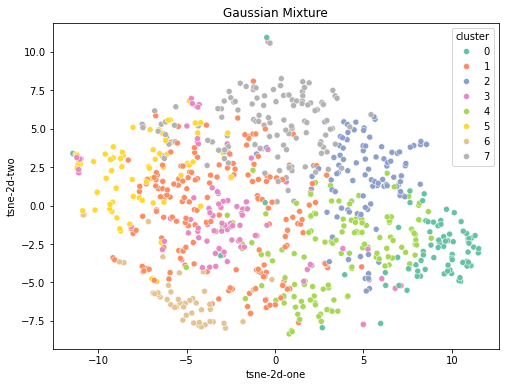

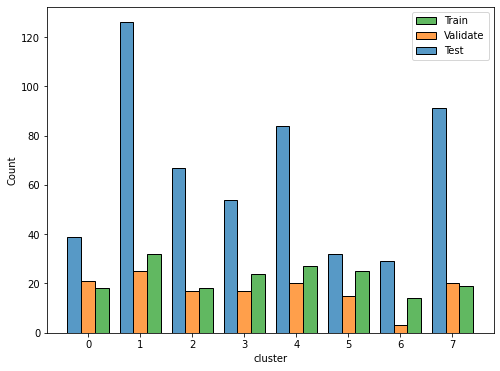

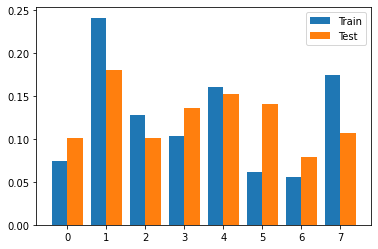

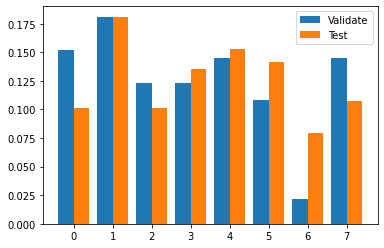

Train vs. test
Power_divergenceResult(statistic=32.014223733724755, pvalue=4.03700432073967e-05)
Val vs. test
Power_divergenceResult(statistic=34.15539666714143, pvalue=1.6108697992963916e-05)


In [8]:
from sklearn.mixture import GaussianMixture
clustering = GaussianMixture(n_components=N_clusters, random_state=0).fit(X)
results['cluster'] = pd.Categorical(clustering.predict(X))

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    data=results,
    palette=sns.color_palette("Set2"),
    legend="full",
)
plt.title("Gaussian Mixture")

print(M.silhouette_score(X,results['cluster']))

plt.figure(figsize=(8,6))
sns.histplot(
    data=results,
    x="cluster",
    hue="y",
    multiple="dodge",
    shrink=.8)
plt.legend(["Train","Validate","Test"])
plt.show()

results_df = pd.DataFrame(results)
f_train = results_df['cluster'][results_df['y']==0].value_counts(sort=False)
f_val = results_df['cluster'][results_df['y']==1].value_counts(sort=False)
f_test = results_df['cluster'][results_df['y']==2].value_counts(sort=False)

plt.figure()
plt.bar(np.arange(8)-0.2, f_train/f_train.sum(), 0.4)
plt.bar(np.arange(8)+0.2, f_test/f_test.sum(), 0.4)
plt.legend(["Train","Test"])
plt.show()

plt.figure()
plt.bar(np.arange(8)-0.2, f_val/f_val.sum(), 0.4)
plt.bar(np.arange(8)+0.2, f_test/f_test.sum(), 0.4)
plt.legend(["Validate","Test"])
plt.show()

print("Train vs. test")
print(stats.chisquare(f_obs=f_test, f_exp=f_train/f_train.sum()*f_test.sum()))
print("Val vs. test")
print(stats.chisquare(f_obs=f_test, f_exp=f_val/f_val.sum()*f_test.sum()))